# Assignment 4 - MLP

In this assignment, we will build a basic MLP in PyTorch and run it against the Wine Quality dataset from Kaggle/UCI Data Repository. We will also tune the MLP to get maximum performance and see what changes impact the performance.

## Import data

We will first import the wine quality data and perform a brief EDA.

In [59]:
# import modules needed for code

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import copy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [60]:
df = pd.read_csv('winequality-red.csv')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [62]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [63]:
df.quality.value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

Upon import of the data, we can see that the dataset has 1599 rows of data and 12 total columns (11 of which will be used as features and the last column is the target). The dataset is fairly clean with no missing values. All features are float, with the target "quality" being an integer. We can also see that the values for "quality" is between 3 to 8. The majority of wines fall within the 5 to 7 range, with the rest of the values being less common. 

We can do brief univariate and bivariate analysis on the features as shown below.

In [64]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


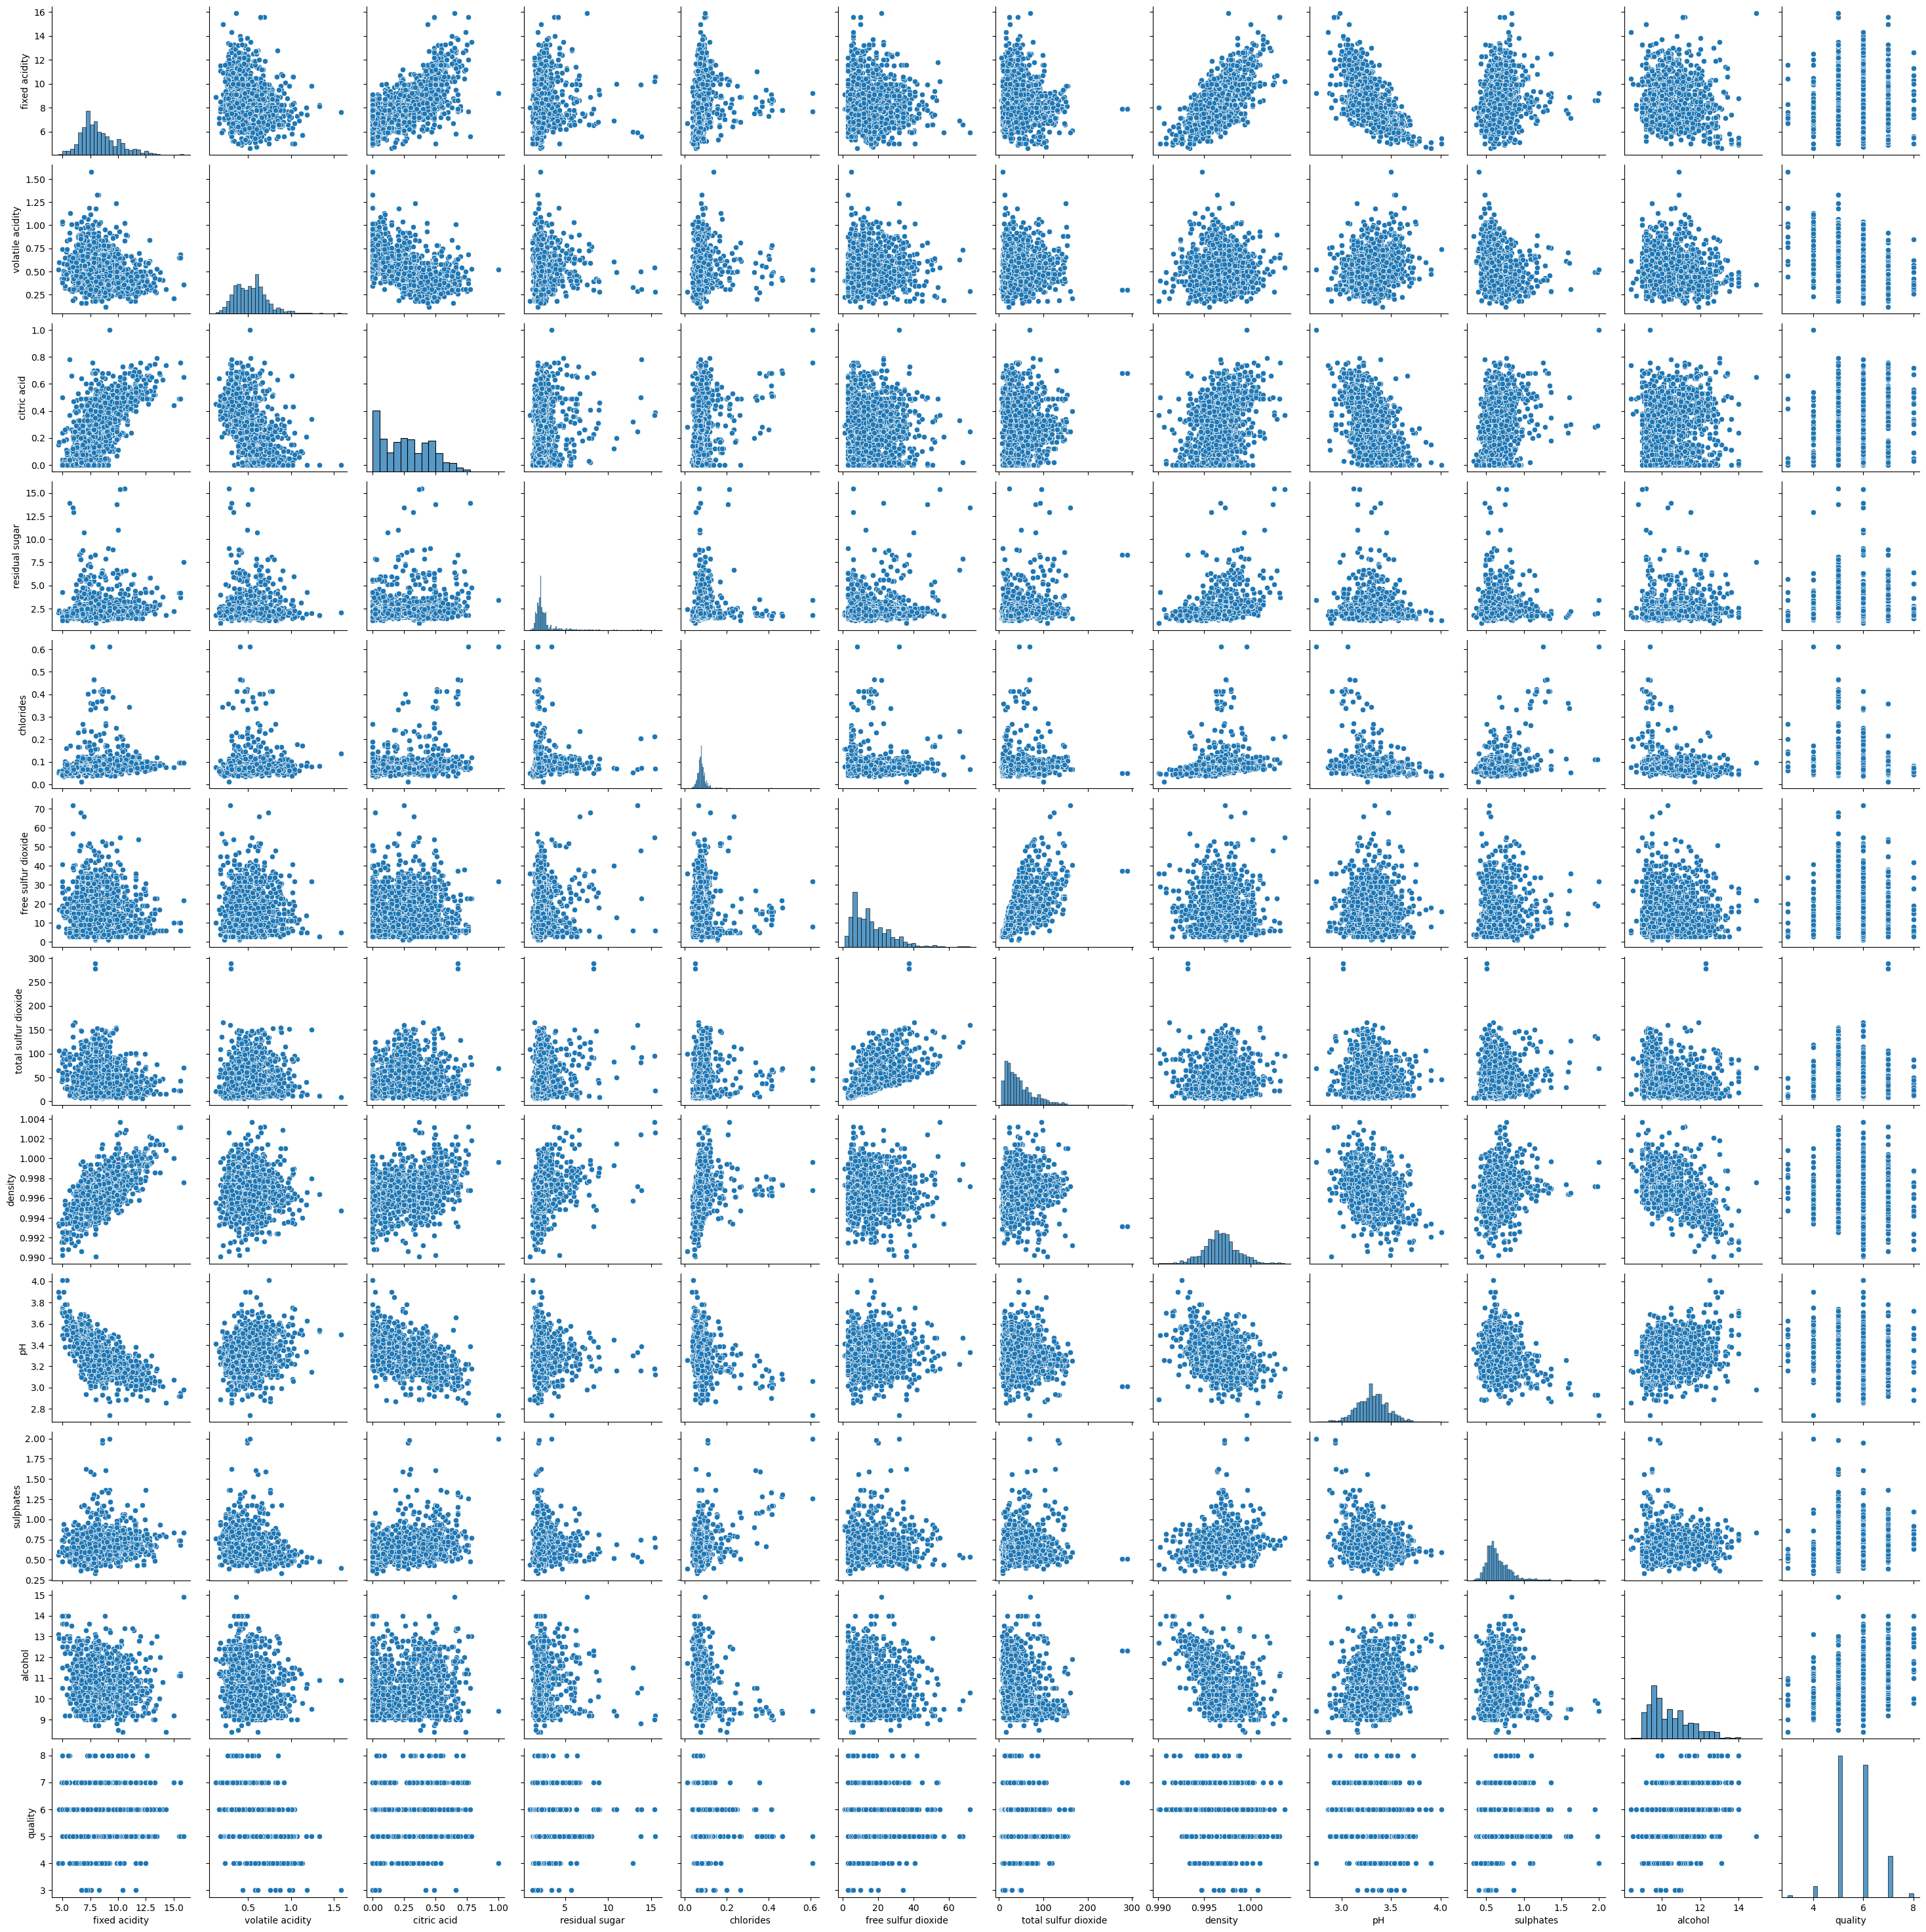

In [65]:
sns.pairplot(df)

<Axes: >

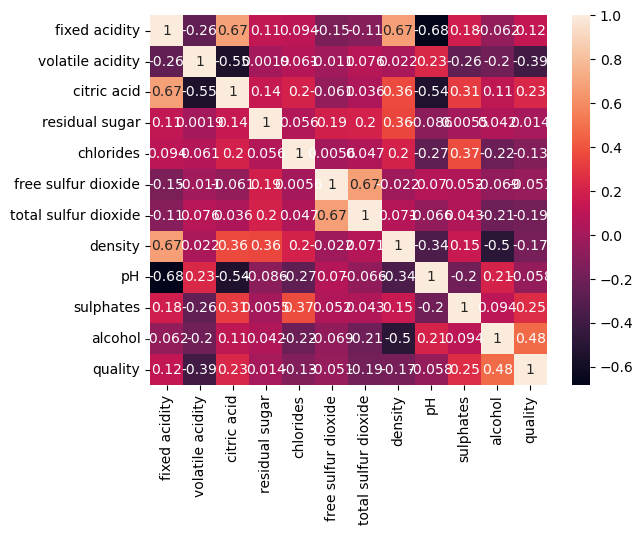

In [66]:
sns.heatmap(data=df.corr(), annot=True)

The correlation and pairplots along with the heatmap shows that there are some features that have strong correlation with each other. For example, "fixed acidity" is strongly correclated with "citric acid", "density", and "pH". "Alcohol" is also relatively strongly correlated with "quality". 

Since we approach this problem using a neural network approach, these factors are good to keep in mind, but we may find that we do not have to do as much data cleaning or data analysis as with earlier techniques. We will move forward with preparing a baseline model.

## Prep For Model

We can approach this problem as either a classification or regression problem since the wine quality is an integer. We will evaluate this as a regression problem and use Mean Square Error (MSE) as the accuracy metric.

We first split the dataset into features and target.

In [67]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [68]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [69]:
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

We will then use train_test_split to split the dataset into 70% training data, 15% validation data, and 15% test data.

In [70]:
main_train_x, ee_x, main_train_y, ee_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
main_train_x.shape

(1119, 11)

In [72]:
main_valid_x, main_test_x, main_valid_y, main_test_y = train_test_split(ee_x, ee_y, test_size=0.5, random_state=42)

In [73]:
print("valid_x.shape:", main_valid_x.shape)
print("valid_y.shape:", main_valid_y.shape)
print("test_x.shape:", main_test_x.shape)
print("test_y.shape:", main_test_y.shape)

valid_x.shape: (240, 11)
valid_y.shape: (240,)
test_x.shape: (240, 11)
test_y.shape: (240,)


In [74]:
main_train_y.shape

(1119,)

From previous attempts at running this code, I noticed that the shape of the target data may result in suboptimal predictions when run through the PyTorch MLP. The PyTorch MLP produces predictions in a tensor with shape of (XXX, 1) while my current shape is (XXX, ). So I looked at ways of formatting the shape of the target data to match up with the shape of the expected output from the PyTorch MLP. Below is some example code I found:

In [75]:
## testing making train_y into a (XXX, 1) tensor
## https://stackoverflow.com/questions/65219569/pytorch-gives-incorrect-results-due-to-broadcasting

Y_tensor = torch.tensor(main_train_y.to_numpy())
print(Y_tensor)
print(Y_tensor.shape)
# torch.tensor(train_y.to_numpy()).shape
new_shape = (len(Y_tensor), 1)
Y_tensor = Y_tensor.view(new_shape)
print(Y_tensor)
print(Y_tensor.shape)

tensor([7, 5, 5,  ..., 5, 7, 6])
torch.Size([1119])
tensor([[7],
        [5],
        [5],
        ...,
        [5],
        [7],
        [6]])
torch.Size([1119, 1])


We can see that the shape of the output is in the expected format after running above code, so we simply need to make both X and y data into correctly-sized tensors that we can feed into the MLP.

In [76]:
train_x = torch.tensor(main_train_x.to_numpy())

In [77]:
train_x

tensor([[ 8.6000,  0.2200,  0.3600,  ...,  3.4700,  0.8700, 11.0000],
        [12.5000,  0.4600,  0.6300,  ...,  2.9900,  0.8700, 10.2000],
        [ 7.2000,  0.5400,  0.2700,  ...,  3.3900,  0.7100, 11.0000],
        ...,
        [ 7.2000,  0.6200,  0.0600,  ...,  3.5100,  0.5400,  9.5000],
        [ 7.9000,  0.2000,  0.3500,  ...,  3.3200,  0.8000, 11.9000],
        [ 5.8000,  0.2900,  0.2600,  ...,  3.3900,  0.5400, 13.5000]],
       dtype=torch.float64)

In [78]:
train_x = train_x.float()
train_x

tensor([[ 8.6000,  0.2200,  0.3600,  ...,  3.4700,  0.8700, 11.0000],
        [12.5000,  0.4600,  0.6300,  ...,  2.9900,  0.8700, 10.2000],
        [ 7.2000,  0.5400,  0.2700,  ...,  3.3900,  0.7100, 11.0000],
        ...,
        [ 7.2000,  0.6200,  0.0600,  ...,  3.5100,  0.5400,  9.5000],
        [ 7.9000,  0.2000,  0.3500,  ...,  3.3200,  0.8000, 11.9000],
        [ 5.8000,  0.2900,  0.2600,  ...,  3.3900,  0.5400, 13.5000]])

In [79]:
def makeCorrectSizedTensor(arr):
    Y_tensor = torch.tensor(arr)
    new_shape = (len(Y_tensor), 1)
    Y_tensor = Y_tensor.view(new_shape)
    return Y_tensor

In [80]:
valid_x, test_x = map(torch.tensor, (main_valid_x.to_numpy(), main_test_x.to_numpy()))
valid_x = valid_x.float()
test_x = test_x.float()
train_y, valid_y, test_y = map(makeCorrectSizedTensor, (main_train_y.to_numpy(), main_valid_y.to_numpy(), main_test_y.to_numpy()))
train_y

tensor([[7],
        [5],
        [5],
        ...,
        [5],
        [7],
        [6]])

In [81]:
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.x = X
        self.y = y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return len(self.x)

In [82]:
train_data = WineDataset(train_x, train_y)
valid_data = WineDataset(valid_x, valid_y)
test_data = WineDataset(test_x, test_y)

In [83]:
train_loader = DataLoader(dataset=train_data, batch_size=8)

We have all data converted to tensors and in format ready to load into a basic MLP.

## Creating a basic MLP

Our basic MLP will have the following setup:
- 1 hidden layer with 5 units
- SGD Optimizer
- ReLU activation
- Learning rate of 0.0001

The below class reflects this setup.

In [84]:
class BasicWineMLP(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(BasicWineMLP, self).__init__()
        
        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs
        
        self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
        self.output = torch.nn.Linear(self.hidden, self.outputs)
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.output(out)
        return out

I also preemptively added functions that would stop the training when validation loss starts to increase after a certain number of iterations.

In [85]:
def isIncreasing(loss_arr, iterations):
    isIncreasingBool = True
    if len(loss_arr) < iterations * 2:
        return not isIncreasingBool
    else:
        arr = loss_arr[-iterations:]
        for loss, loss1 in zip(arr, arr[1:]):
            if loss1 <= loss:
                isIncreasingBool = False
                break
    return isIncreasingBool


def continueTraining(train_loss, valid_loss, iterations):
    if len(train_loss) < iterations * 2 or len(valid_loss) < iterations * 2 or not isIncreasing(valid_loss, iterations):
        return True
    else:
        return False
    
increasingArrLen6 = [0., 0.05, 0.1, 0.15, 0.2, 0.25]
decreasingArrLen6 = [0.25, 0.2, 0.15, 0.1, 0.05, 0.]
constantArrLen6 = [0., 0., 0., 0., 0., 0.]

increasingArrLen13 = [0., 0., 0., 0., 0., 0., 0., 0., 0.05, 0.1, 0.15, 0.2, 0.25]
decreasingArrLen13 = [0., 0., 0., 0., 0., 0., 0., 0.25, 0.2, 0.15, 0.1, 0.05, 0.]
constantArrLen13 = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

print("expect false:", isIncreasing(increasingArrLen6, 5))
print("expect false:", isIncreasing(decreasingArrLen6, 5))
print("expect false:", isIncreasing(constantArrLen6, 5))

print("expect true:", isIncreasing(increasingArrLen13, 5))
print("expect false:", isIncreasing(decreasingArrLen13, 5))
print("expect false:", isIncreasing(constantArrLen13, 5))

print("expect False:", continueTraining(increasingArrLen13, increasingArrLen13, 5))
print("expect True:", continueTraining(increasingArrLen13, decreasingArrLen13, 5))
print("expect True:", continueTraining(increasingArrLen13, constantArrLen13, 5))

expect false: False
expect false: False
expect false: False
expect true: True
expect false: False
expect false: False
expect False: False
expect True: True
expect True: True


Once that is done, we can now actually start training our model with epochs set to 1000 (with early stopping enabled).

We also keep track of the best MSE and the weights and biases associated with the model that produces the best MSE so that we can load the model with the correct weights and biases once training is done and testing with the test set can begin.

ending at epoch 62
training ended at epoch 63


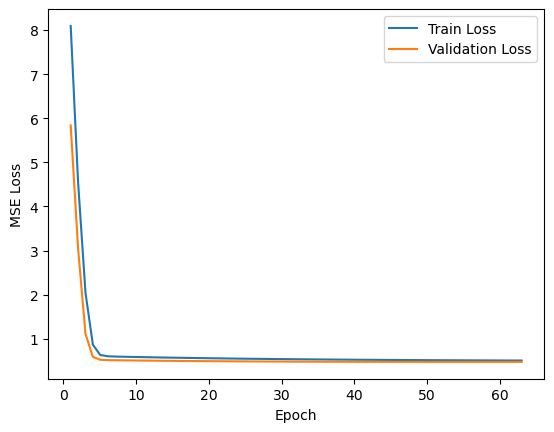

In [31]:
model = BasicWineMLP(11, 5, 1)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.0001)

# Training loop

epochs = 1000
curr_epoch = 1
train_loss = []
valid_loss = []
best_mse = np.inf
best_weights = None
cutoff_iterations = 5 ## limit to < 10
    
for epoch in range(epochs):
    if not continueTraining(train_loss, valid_loss, cutoff_iterations):
        print("ending at epoch", epoch)
        break
    batch_loss = []
    model.train()
    # Train a batch
    for features, targets in train_loader:
        # Get output
        output = model.forward(features)
        # # Calculate the loss
        loss = criterion(output, targets.float())
        batch_loss.append(loss.item())
        optimiser.zero_grad() # Remove previous gradients
        loss.backward() # What the updates should be
        optimiser.step() # Update weights and biases
    # For each epoch
    model.eval()
    # Training loss
    train_loss.append(sum(batch_loss) / len(batch_loss))
    # Valid loss, etc.
    hyp_valid = model.forward(valid_x)
    curr_valid_loss = criterion(hyp_valid, valid_y.float())
    valid_loss.append(curr_valid_loss.item())
    curr_epoch += 1
    if curr_valid_loss < best_mse:
        best_mse = curr_valid_loss
        best_weights = copy.deepcopy(model.state_dict())

# epochs vs train && epochs vs valid
print("training ended at epoch", curr_epoch)

# https://machinelearningmastery.com/building-a-regression-model-in-pytorch/ -> reference for saving best_mse and weights and biases of best model

def plot_loss_curves(epochs, train_loss, valid_loss):
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.title('MSE Losses vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

plot_loss_curves(np.linspace(1, curr_epoch, curr_epoch-1), train_loss, valid_loss)

We can see that early stopping is indeed useful. We can also look a little closer at the curves of the graph towards the end of training.

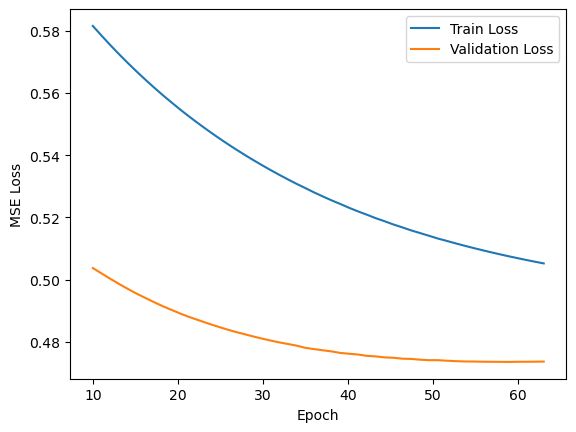

In [32]:
plot_loss_curves(np.linspace(10, curr_epoch, curr_epoch-11), train_loss[10:], valid_loss[10:])

We load back in the weights and biases of the best model and run the test data through it and find the MSE on the test data.

In [33]:
# load back in the best model:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [34]:
test_x

tensor([[ 6.1000,  0.4800,  0.0900,  ...,  3.4500,  0.5400, 11.2000],
        [ 6.1000,  0.7150,  0.1000,  ...,  3.5700,  0.5000, 11.9000],
        [ 5.4000,  0.4200,  0.2700,  ...,  3.7800,  0.6400, 12.3000],
        ...,
        [ 9.4000,  0.4000,  0.3100,  ...,  3.0700,  0.6300, 10.5000],
        [ 6.2000,  0.7850,  0.0000,  ...,  3.5900,  0.6100, 10.0000],
        [ 5.7000,  0.6000,  0.0000,  ...,  3.4500,  0.5600, 12.2000]])

In [35]:
## evaluate accuracy

test_hyp = model.forward(test_x)
test_loss = criterion(test_hyp, test_y.float()).item()
print("The MSE for test set using basic MLP setup is:", test_loss)

The MSE for test set using basic MLP setup is: 0.5112201571464539


We now know the MSE, but it could be useful to see a plot of actual vs predicted values for all samples in the test data.

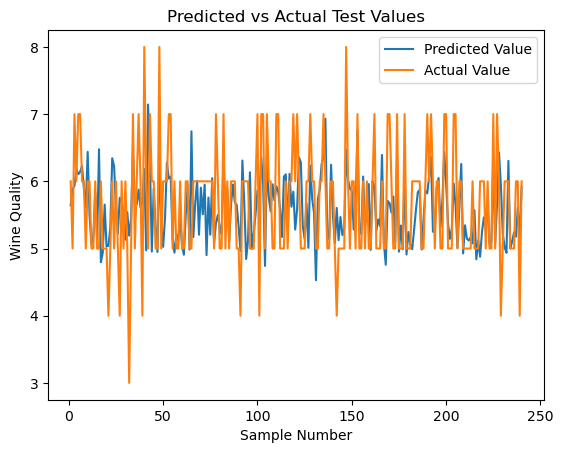

In [36]:
hyp_arr = []
actual_arr = []
for hyp_y, test_y_item in zip(test_hyp, test_y):
    hyp_arr.append(hyp_y[0].float().detach().numpy().item())
    actual_arr.append(test_y_item[0].float().detach().numpy().item())
    # type(test_y[0][0].detach().numpy().item())

plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), hyp_arr, label='Predicted Value')
plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), actual_arr, label='Actual Value')
plt.title('Predicted vs Actual Test Values')
plt.xlabel('Sample Number')
plt.ylabel('Wine Quality')
plt.legend()
plt.show()

From above, we can see that most of our predictions are between the ranges of 5 and 7, which is close to the mean and the majority of wine ratings. Even if our model predicts simply the mean, our MSE would not be much worse than it is now. This serves as a good baseline model to begin tuning of parameters.

## Making changes to basic MLP

Now that we know how to create a baseline model, we will start making changes to the data and hyperparameters and see if we can gain an improvement in the performance. The first thing we will try is normalizing input. We will use sklearn's StandardScaler to do so.

In [86]:
# Step 1: Try to Normalize Input Only

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

class ImprovedWineMLP(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(ImprovedWineMLP, self).__init__()
        
        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs
        
        self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
        self.output = torch.nn.Linear(self.hidden, self.outputs)
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.output(out)
        return out

In [87]:
train_x_ss = scaler.fit_transform(main_train_x)
train_x_ss

array([[ 1.69536131e-01, -1.72107140e+00,  4.59303345e-01, ...,
         1.01180685e+00,  1.22661179e+00,  5.50057013e-01],
       [ 2.44606730e+00, -4.01957443e-01,  1.84105501e+00, ...,
        -2.10687612e+00,  1.22661179e+00, -2.05174641e-01],
       [-6.47680186e-01,  3.77472102e-02, -1.28054303e-03, ...,
         4.92026353e-01,  2.97270776e-01,  5.50057013e-01],
       ...,
       [-6.47680186e-01,  4.77451864e-01, -1.07597628e+00, ...,
         1.27169710e+00, -6.90154049e-01, -8.66002338e-01],
       [-2.39072027e-01, -1.83099757e+00,  4.08127357e-01, ...,
         3.72184202e-02,  8.20025095e-01,  1.39969262e+00],
       [-1.46489650e+00, -1.33632983e+00, -5.24565306e-02, ...,
         4.92026353e-01, -6.90154049e-01,  2.91015593e+00]])

In [88]:
train_x_ss = torch.tensor(train_x_ss).float()
train_x_ss

tensor([[ 1.6954e-01, -1.7211e+00,  4.5930e-01,  ...,  1.0118e+00,
          1.2266e+00,  5.5006e-01],
        [ 2.4461e+00, -4.0196e-01,  1.8411e+00,  ..., -2.1069e+00,
          1.2266e+00, -2.0517e-01],
        [-6.4768e-01,  3.7747e-02, -1.2805e-03,  ...,  4.9203e-01,
          2.9727e-01,  5.5006e-01],
        ...,
        [-6.4768e-01,  4.7745e-01, -1.0760e+00,  ...,  1.2717e+00,
         -6.9015e-01, -8.6600e-01],
        [-2.3907e-01, -1.8310e+00,  4.0813e-01,  ...,  3.7218e-02,
          8.2003e-01,  1.3997e+00],
        [-1.4649e+00, -1.3363e+00, -5.2457e-02,  ...,  4.9203e-01,
         -6.9015e-01,  2.9102e+00]])

In [89]:
valid_x, test_x = map(scaler.transform, (main_valid_x, main_test_x))
valid_x

array([[-0.41418981,  0.83471189, -0.20598449, ..., -0.67747976,
        -0.28356736, -1.05481025],
       [-0.00558165,  0.42248878,  0.15224742, ...,  0.55699892,
        -0.28356736, -0.20517464],
       [-0.99791575,  1.05456422, -0.92244832, ...,  0.23213611,
        -0.98057311,  0.3612491 ],
       ...,
       [-0.64768019,  0.20263646, -1.12715227, ...,  0.42705379,
        -0.34165117, -0.11077068],
       [ 0.92837985,  0.31256262, -1.02480029, ..., -0.02775414,
         0.29727078, -0.58279047],
       [ 0.75326207, -0.18210512,  0.45930334, ..., -0.87239745,
         0.12301934,  0.45565306]])

In [90]:
valid_x_ss = torch.tensor(valid_x).float()
test_x_ss = torch.tensor(test_x).float()
valid_x_ss

tensor([[-0.4142,  0.8347, -0.2060,  ..., -0.6775, -0.2836, -1.0548],
        [-0.0056,  0.4225,  0.1522,  ...,  0.5570, -0.2836, -0.2052],
        [-0.9979,  1.0546, -0.9224,  ...,  0.2321, -0.9806,  0.3612],
        ...,
        [-0.6477,  0.2026, -1.1272,  ...,  0.4271, -0.3417, -0.1108],
        [ 0.9284,  0.3126, -1.0248,  ..., -0.0278,  0.2973, -0.5828],
        [ 0.7533, -0.1821,  0.4593,  ..., -0.8724,  0.1230,  0.4557]])

In [91]:
train_y, valid_y, test_y = map(makeCorrectSizedTensor, (main_train_y.to_numpy(), main_valid_y.to_numpy(), main_test_y.to_numpy()))
train_y

tensor([[7],
        [5],
        [5],
        ...,
        [5],
        [7],
        [6]])

In [92]:
train_data = WineDataset(train_x_ss, train_y)
valid_data = WineDataset(valid_x_ss, valid_y)
test_data = WineDataset(test_x_ss, test_y)

train_loader = DataLoader(dataset=train_data, batch_size=8)

The features are normalized (the target is not). We will then create a model using normalized data and leaving all other settings the same and see what improvements we may get.

training ended at epoch 1001


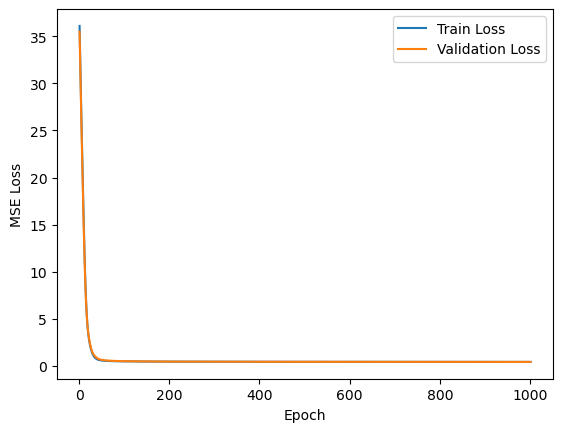

In [45]:
model = ImprovedWineMLP(11, 5, 1)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.0001)

# Training loop

epochs = 1000
curr_epoch = 1
train_loss = []
valid_loss = []
best_mse = np.inf
best_weights = None
cutoff_iterations = 5 ## limit to < 10
    
for epoch in range(epochs):
    if not continueTraining(train_loss, valid_loss, cutoff_iterations):
        print("ending at epoch", epoch)
        break
    batch_loss = []
    model.train()
    # Train a batch
    for features, targets in train_loader:
        # Get output
        output = model.forward(features)
        # # Calculate the loss
        loss = criterion(output, targets.float())
        batch_loss.append(loss.item())
        optimiser.zero_grad() # Remove previous gradients
        loss.backward() # What the updates should be
        optimiser.step() # Update weights and biases
    # For each epoch
    model.eval()
    # # Training loss
    train_loss.append(sum(batch_loss) / len(batch_loss))
    # # Valid loss, etc.
    hyp_valid = model.forward(valid_x_ss)
    curr_valid_loss = criterion(hyp_valid, valid_y.float())
    valid_loss.append(curr_valid_loss.item())
    curr_epoch += 1
    if curr_valid_loss < best_mse:
        best_mse = curr_valid_loss
        best_weights = copy.deepcopy(model.state_dict())

# epochs vs train && epochs vs valid
print("training ended at epoch", curr_epoch)

# https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

def plot_loss_curves(epochs, train_loss, valid_loss):
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

plot_loss_curves(np.linspace(1, curr_epoch, curr_epoch-1), train_loss, valid_loss)

In [46]:
# load back in the best model:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [48]:
## evaluate accuracy

test_hyp = model.forward(test_x_ss)
test_loss = criterion(test_hyp, test_y.float()).item()
print("The MSE for test set using Improved MLP setup is:", test_loss)

The MSE for test set using Improved MLP setup is: 0.4041779637336731


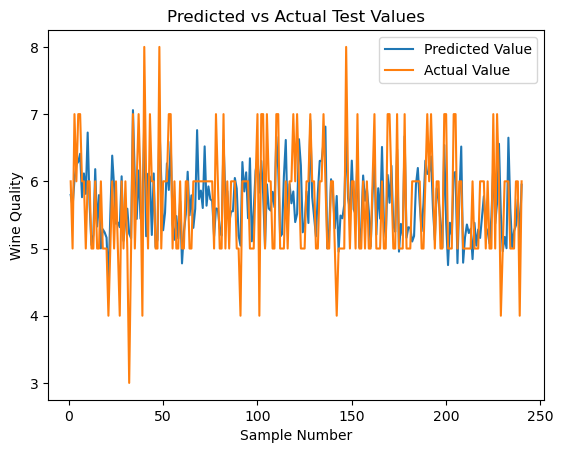

In [49]:
hyp_arr = []
actual_arr = []
for hyp_y, test_y_item in zip(test_hyp, test_y):
    hyp_arr.append(hyp_y[0].float().detach().numpy().item())
    actual_arr.append(test_y_item[0].float().detach().numpy().item())

plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), hyp_arr, label='Predicted Value')
plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), actual_arr, label='Actual Value')
plt.title('Predicted vs Actual Test Values')
plt.xlabel('Sample Number')
plt.ylabel('Wine Quality')
plt.legend()
plt.show()

The above result shows an almost 20% improvement in the accuracy on the test dataset! We will keep using normalized input for future tuning since it makes such a big difference.

We will now try adding a 2nd hidden layer to the MLP (and adding a BatchNorm layer in between the hidden layers) and see what effect this has. 

In [93]:
# Step 2: Increase # of hidden layers

class ImprovedWineMLP2(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(ImprovedWineMLP2, self).__init__()
        
        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs
        
        self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
        self.norm1 = torch.nn.BatchNorm1d(self.hidden)
        self.fc2 = torch.nn.Linear(self.hidden, self.hidden)
        self.output = torch.nn.Linear(self.hidden, self.outputs)
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.output(out)
        return out

ending at epoch 185
training ended at epoch 186


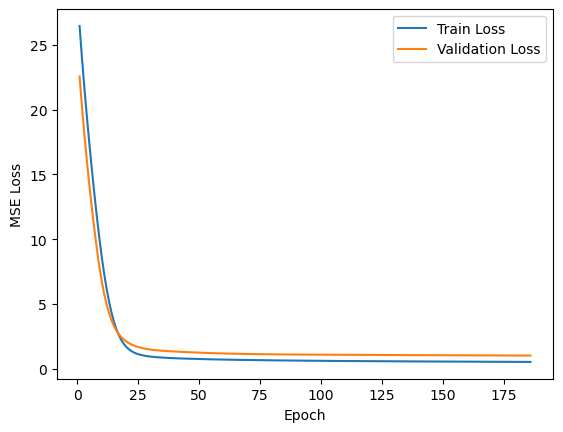

In [94]:
model = ImprovedWineMLP2(11, 5, 1)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.0001)

# Training loop

epochs = 1000
curr_epoch = 1
train_loss = []
valid_loss = []
best_mse = np.inf
best_weights = None
cutoff_iterations = 5 ## limit to < 10
    
for epoch in range(epochs):
    if not continueTraining(train_loss, valid_loss, cutoff_iterations):
        print("ending at epoch", epoch)
        break
    batch_loss = []
    model.train()
    # Train a batch
    for features, targets in train_loader:
        # Get output
        output = model.forward(features)
        # # Calculate the loss
        loss = criterion(output, targets.float())
        batch_loss.append(loss.item())
        optimiser.zero_grad() # Remove previous gradients
        loss.backward() # What the updates should be
        optimiser.step() # Update weights and biases
    # For each epoch
    model.eval()
    # # Training loss
    train_loss.append(sum(batch_loss) / len(batch_loss))
    # # Valid loss, etc.
    hyp_valid = model.forward(valid_x_ss)
    curr_valid_loss = criterion(hyp_valid, valid_y.float())
    valid_loss.append(curr_valid_loss.item())
    curr_epoch += 1
    if curr_valid_loss < best_mse:
        best_mse = curr_valid_loss
        best_weights = copy.deepcopy(model.state_dict())

# epochs vs train && epochs vs valid
print("training ended at epoch", curr_epoch)

# https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

def plot_loss_curves(epochs, train_loss, valid_loss):
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

plot_loss_curves(np.linspace(1, curr_epoch, curr_epoch-1), train_loss, valid_loss)

The MSE for test set using Improved MLP 2 setup is: 0.9429641962051392


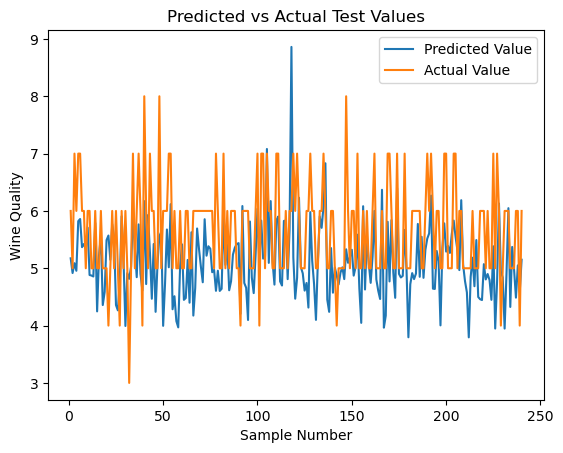

In [95]:
# load back in the best model:
model.load_state_dict(best_weights)

## evaluate accuracy

test_hyp = model.forward(test_x_ss)
test_loss = criterion(test_hyp, test_y.float()).item()
print("The MSE for test set using Improved MLP 2 setup is:", test_loss)

hyp_arr = []
actual_arr = []
for hyp_y, test_y_item in zip(test_hyp, test_y):
    hyp_arr.append(hyp_y[0].float().detach().numpy().item())
    actual_arr.append(test_y_item[0].float().detach().numpy().item())

plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), hyp_arr, label='Predicted Value')
plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), actual_arr, label='Actual Value')
plt.title('Predicted vs Actual Test Values')
plt.xlabel('Sample Number')
plt.ylabel('Wine Quality')
plt.legend()
plt.show()

training ended at epoch 1001


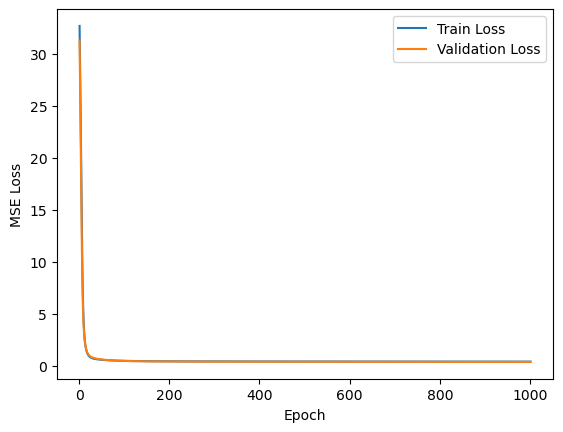

In [96]:
# Step 2: Increase # of hidden layers

class ImprovedWineMLP2(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(ImprovedWineMLP2, self).__init__()
        
        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs
        
        self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
        self.norm1 = torch.nn.BatchNorm1d(self.hidden)
        self.fc2 = torch.nn.Linear(self.hidden, self.hidden)
        self.output = torch.nn.Linear(self.hidden, self.outputs)
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.output(out)
        return out

model = ImprovedWineMLP2(11, 5, 1)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.0001)

# Training loop

epochs = 1000
curr_epoch = 1
train_loss = []
valid_loss = []
best_mse = np.inf
best_weights = None
cutoff_iterations = 5 ## limit to < 10
    
for epoch in range(epochs):
    if not continueTraining(train_loss, valid_loss, cutoff_iterations):
        print("ending at epoch", epoch)
        break
    batch_loss = []
    model.train()
    # Train a batch
    for features, targets in train_loader:
        # Get output
        output = model.forward(features)
        # # Calculate the loss
        loss = criterion(output, targets.float())
        batch_loss.append(loss.item())
        optimiser.zero_grad() # Remove previous gradients
        loss.backward() # What the updates should be
        optimiser.step() # Update weights and biases
    # For each epoch
    model.eval()
    # # Training loss
    train_loss.append(sum(batch_loss) / len(batch_loss))
    # # Valid loss, etc.
    hyp_valid = model.forward(valid_x_ss)
    curr_valid_loss = criterion(hyp_valid, valid_y.float())
    valid_loss.append(curr_valid_loss.item())
    curr_epoch += 1
    if curr_valid_loss < best_mse:
        best_mse = curr_valid_loss
        best_weights = copy.deepcopy(model.state_dict())

# epochs vs train && epochs vs valid
print("training ended at epoch", curr_epoch)

# https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

def plot_loss_curves(epochs, train_loss, valid_loss):
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

plot_loss_curves(np.linspace(1, curr_epoch, curr_epoch-1), train_loss, valid_loss)

The MSE for test set using Improved MLP 2 setup is: 0.3990573287010193


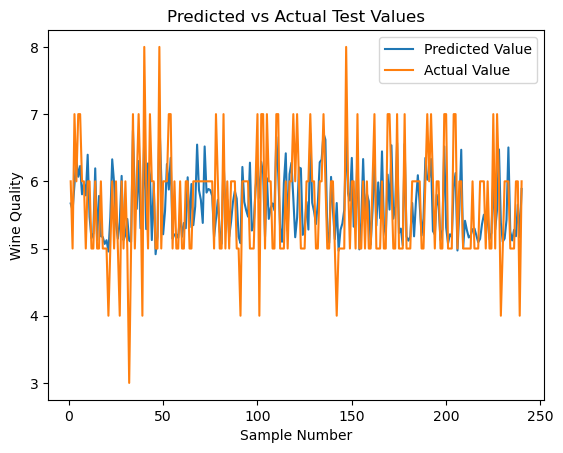

In [97]:
# load back in the best model:
model.load_state_dict(best_weights)

## evaluate accuracy

test_hyp = model.forward(test_x_ss)
test_loss = criterion(test_hyp, test_y.float()).item()
print("The MSE for test set using Improved MLP 2 setup is:", test_loss)

hyp_arr = []
actual_arr = []
for hyp_y, test_y_item in zip(test_hyp, test_y):
    hyp_arr.append(hyp_y[0].float().detach().numpy().item())
    actual_arr.append(test_y_item[0].float().detach().numpy().item())

plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), hyp_arr, label='Predicted Value')
plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), actual_arr, label='Actual Value')
plt.title('Predicted vs Actual Test Values')
plt.xlabel('Sample Number')
plt.ylabel('Wine Quality')
plt.legend()
plt.show()

ending at epoch 994
training ended at epoch 995


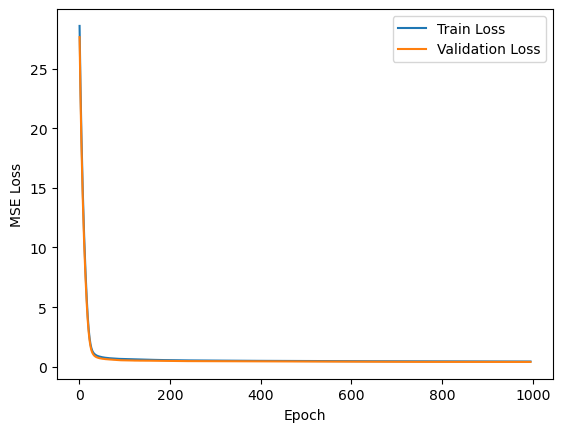

In [98]:
# Step 2: Increase # of hidden layers

class ImprovedWineMLP2(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(ImprovedWineMLP2, self).__init__()
        
        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs
        
        self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
        self.norm1 = torch.nn.BatchNorm1d(self.hidden)
        self.fc2 = torch.nn.Linear(self.hidden, self.hidden)
        self.output = torch.nn.Linear(self.hidden, self.outputs)
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.output(out)
        return out

model = ImprovedWineMLP2(11, 5, 1)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.0001)

# Training loop

epochs = 1000
curr_epoch = 1
train_loss = []
valid_loss = []
best_mse = np.inf
best_weights = None
cutoff_iterations = 5 ## limit to < 10
    
for epoch in range(epochs):
    if not continueTraining(train_loss, valid_loss, cutoff_iterations):
        print("ending at epoch", epoch)
        break
    batch_loss = []
    model.train()
    # Train a batch
    for features, targets in train_loader:
        # Get output
        output = model.forward(features)
        # # Calculate the loss
        loss = criterion(output, targets.float())
        batch_loss.append(loss.item())
        optimiser.zero_grad() # Remove previous gradients
        loss.backward() # What the updates should be
        optimiser.step() # Update weights and biases
    # For each epoch
    model.eval()
    # # Training loss
    train_loss.append(sum(batch_loss) / len(batch_loss))
    # # Valid loss, etc.
    hyp_valid = model.forward(valid_x_ss)
    curr_valid_loss = criterion(hyp_valid, valid_y.float())
    valid_loss.append(curr_valid_loss.item())
    curr_epoch += 1
    if curr_valid_loss < best_mse:
        best_mse = curr_valid_loss
        best_weights = copy.deepcopy(model.state_dict())

# epochs vs train && epochs vs valid
print("training ended at epoch", curr_epoch)

# https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

def plot_loss_curves(epochs, train_loss, valid_loss):
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

plot_loss_curves(np.linspace(1, curr_epoch, curr_epoch-1), train_loss, valid_loss)

The MSE for test set using Improved MLP 2 setup is: 0.47117727994918823


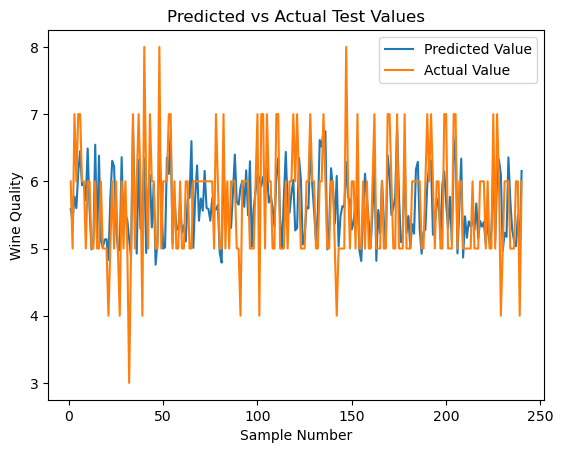

In [99]:
# load back in the best model:
model.load_state_dict(best_weights)

## evaluate accuracy

test_hyp = model.forward(test_x_ss)
test_loss = criterion(test_hyp, test_y.float()).item()
print("The MSE for test set using Improved MLP 2 setup is:", test_loss)

hyp_arr = []
actual_arr = []
for hyp_y, test_y_item in zip(test_hyp, test_y):
    hyp_arr.append(hyp_y[0].float().detach().numpy().item())
    actual_arr.append(test_y_item[0].float().detach().numpy().item())

plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), hyp_arr, label='Predicted Value')
plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), actual_arr, label='Actual Value')
plt.title('Predicted vs Actual Test Values')
plt.xlabel('Sample Number')
plt.ylabel('Wine Quality')
plt.legend()
plt.show()

In [105]:
learning_rate = [0.01, 0.001, 0.0001, 0.00001]
batch_size = [8, 16, 32]
cutoff = [5, 8, 10]

class ImprovedWineMLPUltimate(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(ImprovedWineMLPUltimate, self).__init__()

        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs

        self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
        self.output = torch.nn.Linear(self.hidden, self.outputs)
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.output(out)
        return out

def MLPTraining(lr, batch, cutoff):
    best_mse = np.inf
    best_weights = None
    best_lr = lr[0]
    best_batch = batch[0]
    best_cutoff = cutoff[0]
    best_model = None

    for rate in lr:
        for btch in batch:
            for c in cutoff:        
                model = ImprovedWineMLPUltimate(11, 5, 1)
                criterion = torch.nn.MSELoss()
                optimiser = torch.optim.SGD(params=model.parameters(), lr=rate)

                # Training loop

                total_epochs = 5000
                curr_epoch = 1
                train_loss = []
                valid_loss = []
                cutoff_iterations = c ## limit to < 10

                for e in range(total_epochs):
                    if not continueTraining(train_loss, valid_loss, cutoff_iterations):
                        print("ending at epoch",e)
                        break
                    batch_loss = []
                    model.train()
                    # Train a batch
                    for features, targets in train_loader:
                        # Get output
                        output = model.forward(features)
                        # # Calculate the loss
                        loss = criterion(output, targets.float())
                        batch_loss.append(loss.item())
                        optimiser.zero_grad() # Remove previous gradients
                        loss.backward() # What the updates should be
                        optimiser.step() # Update weights and biases
                    # For each epoch
                    model.eval()
                    # # Training loss
                    train_loss.append(sum(batch_loss) / len(batch_loss))
                    # # Valid loss, etc.
                    hyp_valid = model.forward(valid_x_ss)
                    curr_valid_loss = criterion(hyp_valid, valid_y.float())
                    valid_loss.append(curr_valid_loss.item())
                    curr_epoch += 1
                    if curr_valid_loss < best_mse:
                        best_mse = curr_valid_loss
                        best_weights = copy.deepcopy(model.state_dict())
                        best_lr = rate
                        best_batch = btch
                        best_cutoff = cutoff

                # epochs vs train && epochs vs valid
                print("training ended at epoch", curr_epoch)

    # https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
    print("best_lr:", best_lr)
    print("best batch size:", best_batch)
    print("best_cutoff:", best_cutoff)
    print("best_mse:", best_mse)
#     plot_loss_curves(np.linspace(1, curr_epoch, curr_epoch-1), train_loss, valid_loss)

#     # load back in the best model:
#     model.load_state_dict(best_weights)

#     ## evaluate accuracy

#     test_hyp = model.forward(test_x_ss)
#     test_loss = criterion(test_hyp, test_y.float()).item()
#     print("The MSE for test set using Improved MLP Ultimate setup is:", test_loss)

#     hyp_arr = []
#     actual_arr = []
#     for hyp_y, test_y_item in zip(test_hyp, test_y):
#         hyp_arr.append(hyp_y[0].float().detach().numpy().item())
#         actual_arr.append(test_y_item[0].float().detach().numpy().item())

#     plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), hyp_arr, label='Predicted Value')
#     plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), actual_arr, label='Actual Value')
#     plt.title('Predicted vs Actual Test Values')
#     plt.xlabel('Sample Number')
#     plt.ylabel('Wine Quality')
#     plt.legend()
#     plt.show()
    
MLPTraining(learning_rate, batch_size, cutoff)

ending at epoch 193
training ended at epoch 194
ending at epoch 872
training ended at epoch 873
training ended at epoch 5001
ending at epoch 654
training ended at epoch 655
training ended at epoch 5001
training ended at epoch 5001
ending at epoch 518
training ended at epoch 519
training ended at epoch 5001
training ended at epoch 5001
ending at epoch 169
training ended at epoch 170
ending at epoch 157
training ended at epoch 158
training ended at epoch 5001
ending at epoch 555
training ended at epoch 556
ending at epoch 160
training ended at epoch 161
training ended at epoch 5001
ending at epoch 1139
training ended at epoch 1140
ending at epoch 655
training ended at epoch 656
ending at epoch 564
training ended at epoch 565
ending at epoch 655
training ended at epoch 656
training ended at epoch 5001
training ended at epoch 5001
ending at epoch 2117
training ended at epoch 2118
ending at epoch 190
training ended at epoch 191
training ended at epoch 5001
ending at epoch 375
training ended

ending at epoch 1477
training ended at epoch 1478
best_mse: tensor(0.3879, grad_fn=<MseLossBackward0>)


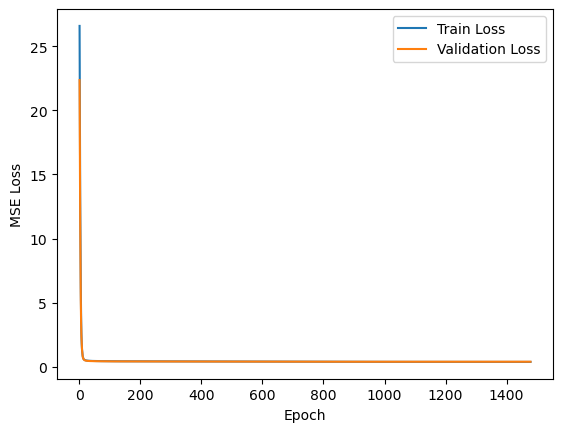

The MSE for test set using Improved MLP Ultimate setup is: 0.3986864686012268


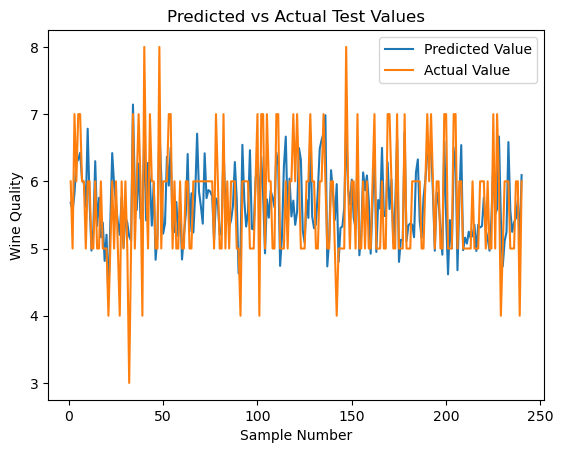

In [120]:
train_loader = DataLoader(dataset=train_data, batch_size=16)

model = ImprovedWineMLPUltimate(11, 5, 1)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.001)

# Training loop

total_epochs = 5000
curr_epoch = 1
train_loss = []
valid_loss = []
best_mse = np.inf
best_weights = None
cutoff_iterations = 5 ## limit to < 10

for e in range(total_epochs):
    if not continueTraining(train_loss, valid_loss, cutoff_iterations):
        print("ending at epoch",e)
        break
    batch_loss = []
    model.train()
    # Train a batch
    for features, targets in train_loader:
        # Get output
        output = model.forward(features)
        # # Calculate the loss
        loss = criterion(output, targets.float())
        batch_loss.append(loss.item())
        optimiser.zero_grad() # Remove previous gradients
        loss.backward() # What the updates should be
        optimiser.step() # Update weights and biases
    # For each epoch
    model.eval()
    # # Training loss
    train_loss.append(sum(batch_loss) / len(batch_loss))
    # # Valid loss, etc.
    hyp_valid = model.forward(valid_x_ss)
    curr_valid_loss = criterion(hyp_valid, valid_y.float())
    valid_loss.append(curr_valid_loss.item())
    curr_epoch += 1
    if curr_valid_loss < best_mse:
        best_mse = curr_valid_loss
        best_weights = copy.deepcopy(model.state_dict())

# epochs vs train && epochs vs valid
print("training ended at epoch", curr_epoch)

# https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
print("best_mse:", best_mse)
plot_loss_curves(np.linspace(1, curr_epoch, curr_epoch-1), train_loss, valid_loss)

# load back in the best model:
model.load_state_dict(best_weights)

## evaluate accuracy

test_hyp = model.forward(test_x_ss)
test_loss = criterion(test_hyp, test_y.float()).item()
print("The MSE for test set using Improved MLP Ultimate setup is:", test_loss)

hyp_arr = []
actual_arr = []
for hyp_y, test_y_item in zip(test_hyp, test_y):
    hyp_arr.append(hyp_y[0].float().detach().numpy().item())
    actual_arr.append(test_y_item[0].float().detach().numpy().item())

plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), hyp_arr, label='Predicted Value')
plt.plot(np.linspace(1, len(hyp_arr), len(hyp_arr)), actual_arr, label='Actual Value')
plt.title('Predicted vs Actual Test Values')
plt.xlabel('Sample Number')
plt.ylabel('Wine Quality')
plt.legend()
plt.show()

# Optional: Implementing the MLP

In [38]:
# Add steps